<a href="https://colab.research.google.com/github/Siqi-Fang/Vehicles_Prediction_TS/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement
[Acknowledgement](https://www.kaggle.com/vetrirah/ml-iot)
##Context
You are working with the government to transform your city into a smart city. The vision is to convert it into a digital and intelligent city to improve the efficiency of services for the citizens. One of the problems faced by the government is traffic. You are a data scientist working to manage the traffic of the city better and to provide input on infrastructure planning for the future.

The government wants to implement a robust traffic system for the city by being prepared for traffic peaks. They want to understand the **traffic patterns of the four junctions of the city**. **Traffic patterns on holidays, as well as on various other occasions during the year, differ from normal working days.** This is important to take into account for your forecasting.

##Content
To predict traffic patterns in each of these four junctions for the next 4 months.

The sensors on each of these junctions were collecting data at different times, hence you will see traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data requiring thoughtfulness when creating future projections. Depending upon the historical data of 20 months, the government is looking to you to deliver accurate traffic projections for the coming four months. Your algorithm will become the foundation of a larger transformation to make your city smart and intelligent.

#Analysis
##Packages

In [ ]:
# pip install statsmodels

In [1]:
# Data Manipulation:
import numpy as np
import pandas as pd

# Data Viz :
import matplotlib.pyplot as plt
import seaborn as sns 
# Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
  # metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
  # models
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# Time Series 
from datetime import datetime 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Load Dataset

See acknowledgment for data source.

In [84]:
train_path = '/content/drive/MyDrive/Colab Notebooks/TS_IOT/train_ML_IOT.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/TS_IOT/test_ML_IOT.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

##Basic Data Info

In [107]:
# Python Method 1 : Displays Data Information :

def display_data_information(data, data_types, dataframe_name):
    print(" Information of ",dataframe_name,": Rows = ",data.shape[0],"| Columns = ",data.shape[1],"\n")
    data.info()
    print("\n")
    for VARIABLE in data_types :
        data_type = data.select_dtypes(include=[ VARIABLE ]).dtypes
        if len(data_type) > 0 :
            print(str(len(data_type))+" "+VARIABLE+" Features\n"+str(data_type)+"\n"  )        

data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]


In [108]:
# display data information of training set 
display_data_information(train, data_types, "Train")

 Information of  Train : Rows =  4344 | Columns =  8 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4344 entries, 43776 to 48119
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Vehicles  4344 non-null   int64
 1   Weekday   4344 non-null   int64
 2   Year      4344 non-null   int64
 3   Month     4344 non-null   int64
 4   Day       4344 non-null   int64
 5   Hour      4344 non-null   int64
 6   Week      4344 non-null   int64
 7   Quarter   4344 non-null   int64
dtypes: int64(8)
memory usage: 305.4 KB


8 int64 Features
Vehicles    int64
Weekday     int64
Year        int64
Month       int64
Day         int64
Hour        int64
Week        int64
Quarter     int64
dtype: object



The time intervals are 1 hr. The data range from 2015-11-01 to 2017-06-30.
Junction: category and number of Vehicles are documented. 

In [ ]:
# display some sample entries
train.head(3).append(train.tail(3))

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [ ]:
train.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [ ]:
train.DateTime.describe()

count                   48120
unique                  14592
top       2017-06-30 23:00:00
freq                        4
Name: DateTime, dtype: object

##Basic Data Cleaning

###Check for duplicated entries between train and test

In [3]:
# prevents data leakage 
# diff = pd.merge(test,train, how='outer')
# diff[diff['ID'].duplicated()].count()

Drop ID columns for training set

In [53]:
train.drop(['ID'], axis = 1, inplace=True)

### Handle Missing Values

In [109]:
train.isna().any()

Vehicles    False
Weekday     False
Year        False
Month       False
Day         False
Hour        False
Week        False
Quarter     False
dtype: bool

###Transform DateTime 

In [ ]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])

train.set_index('DateTime')
test.set_index('DateTime')

##A First Look at Our Target Variable

###Difference Across Time Frequencies

In [ ]:
# To tun this section: restore DateTime  
"""
# Resampling to daily frequency
train_day = train.resample('D').mean()

# Resampling to monthly frequency
train_month = train.resample('M').mean()

# Resampling to annual frequency
train_year = train.resample('A-DEC').mean()

# Resampling to quarterly frequency
train_Q = train.resample('Q-DEC').mean()
"""

In [ ]:
"""
train_hour = train[train.index < 
                   pd.to_datetime('2015-11-03')].resample('H').mean()
train_hour.head()
"""

In [ ]:
# PLOTS
"""
fig = plt.figure(figsize=[17, 7])
plt.suptitle('Vehicles counts', fontsize=22)

plt.subplot(325)
plt.plot(train_hour.Vehicles, '-', label='By Hours')
plt.legend()

plt.subplot(321)
plt.plot(train_day.Vehicles, '-', label='By Days')
plt.legend()

plt.subplot(322)
plt.plot(train_month.Vehicles, '-', label='By Months')
plt.legend()

plt.subplot(323)
plt.plot(train_Q.Vehicles, '-', label='By Quarters')
plt.legend()

plt.subplot(324)
plt.plot(train_year.Vehicles, '-', label='By Years')
plt.legend()


# plt.tight_layout()
plt.show()
"""

### Difference Across Junctions
As stated in the prompt each junction collect data differently, so we graph the data collected in each junction to see how much they differ and decide if we should model each differently.


In [7]:
# create different df for each junction
train_j1 = train[train['Junction']==1].copy()
train_j2 = train[train['Junction']==2].copy()
train_j3 = train[train['Junction']==3].copy()
train_j4 = train[train['Junction']==4].copy()

train_j1.drop(['Junction'],axis=1,inplace=True)
train_j2.drop(['Junction'],axis=1,inplace=True)
train_j3.drop(['Junction'],axis=1,inplace=True)
train_j4.drop(['Junction'],axis=1,inplace=True)

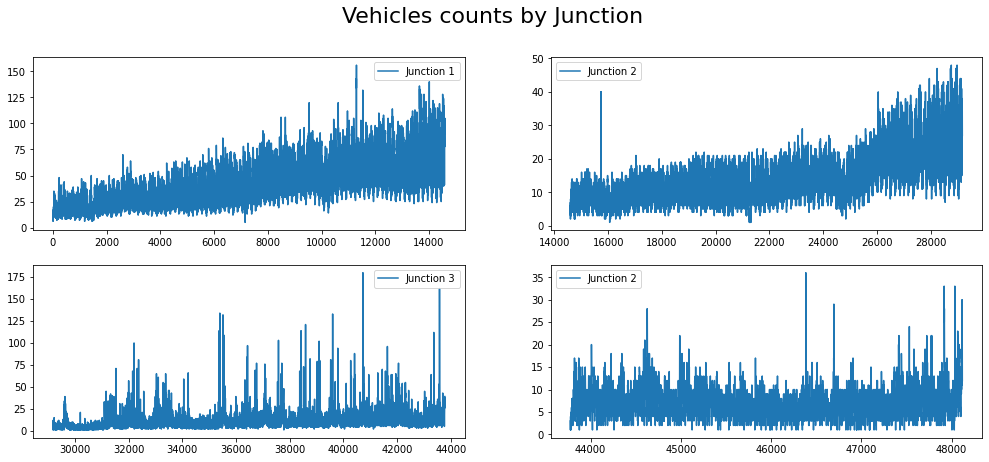

In [106]:
# Plot the data for each model 

fig = plt.figure(figsize=[17, 7])
plt.suptitle('Vehicles counts by Junction', fontsize=22)

plt.subplot(221)
plt.plot(train_j1.Vehicles, '-', label='Junction 1')
plt.legend()

plt.subplot(222)
plt.plot(train_j2.Vehicles, '-', label='Junction 2')
plt.legend()

plt.subplot(223)
plt.plot(train_j3.Vehicles, '-', label='Junction 3')
plt.legend()

plt.subplot(224)
plt.plot(train_j4.Vehicles, '-', label='Junction 2')
plt.legend()

plt.show()


 Since the data differ without certain pattern, we will do forecasting for each junction seperately. 

We need to also split the test data.

In [86]:
# Split test data by junctions
test_j1 = test[test['Junction']==1].copy()
test_j2 = test[test['Junction']==2].copy()
test_j3 = test[test['Junction']==3].copy()
test_j4 = test[test['Junction']==4].copy()

test_j1.drop(['Junction'],axis=1,inplace=True)
test_j2.drop(['Junction'],axis=1,inplace=True)
test_j3.drop(['Junction'],axis=1,inplace=True)
test_j4.drop(['Junction'],axis=1,inplace=True)

##Feature Engineering 

###Create Features
The goal is to analyze the traffic pattern
 * [x] across 4 junctions
 * [ ] on holidays
 * [ ] workdays


In [10]:
def createTimeFeatures(data):
    data['Weekday'] = [datetime.weekday(date) for date in data.DateTime]
    data['Year'] = [date.year for date in data.DateTime]
    data['Month'] = [date.month for date in data.DateTime]
    data['Day'] = [date.day for date in data.DateTime]
    data['Hour'] = [date.hour for date in data.DateTime]
    data['Week'] = [date.week for date in data.DateTime]
    data['Quarter'] = [date.quarter for date in data.DateTime]

In [11]:
# Create Time Features for each dataset
createTimeFeatures(train_j1)
createTimeFeatures(train_j2)
createTimeFeatures(train_j3)
createTimeFeatures(train_j4)

In [87]:
createTimeFeatures(test_j1)
createTimeFeatures(test_j2)
createTimeFeatures(test_j3)
createTimeFeatures(test_j4)

In [88]:
# Drop DateTime column
dfs = [train_j1,train_j2,train_j3,train_j4,
       test_j1,test_j2,test_j3,test_j4]
for df in dfs:
  df.drop(['DateTime'],axis=1,inplace=True)

#Modelling


## Initial Model selection
Each models were tested for performance on each model. The complete process is not documented.

####Evaluation

$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$

$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

In [13]:
def regressEval(real,pred,model):
  mae = mean_absolute_error(real,pred)
  print("The Meas Absolute Value of {} is {}".format(model, mae))
  mse = mean_squared_error(real,pred)
  print("The Meas Squared Value of the {} is {}".format(model,mse))
  rsqr = r2_score(real,pred)
  print("The R square score of the {} is {}".format(model,rsqr))

### Linear Regressoion

In [ ]:
"""
train, test = train_test_split(train_j1,test_size=0.2)
X = train.drop(['Vehicles'], axis = 1)
Y = train['Vehicles']
x_test = test.drop(['Vehicles'], axis = 1)
y_test = test['Vehicles']
"""

In [ ]:
# Train and Fit 
reg = LinearRegression()
reg.fit(X,Y)
# make predictions
reg_pred = reg.predict(x_test)

In [ ]:
regressEval(y_test,reg_pred, 'Linear Regression 4')

The Meas Absolute Value of Linear Regression 4 is 2.219164711311484
The Meas Squared Value of the Linear Regression 4 is 9.557593614290715
The R square score of the Linear Regression 4 is 0.263589705228493


###Gaussian Process Regressor(GPR)


In [ ]:

gpr = GaussianProcessRegressor(random_state = 0)
gpr.fit(X,Y)

gpr_pred = gpr.predict(x_test)


In [ ]:
regressEval(y_test,gpr_pred, 'GPR_J4')

The Meas Absolute Value of GPR_J4 is 2.6434012307327075
The Meas Squared Value of the GPR_J4 is 11.706352302827447
The R square score of the GPR_J4 is 0.0980283638410353


### XGBRegressor

In [ ]:
"""
xgbr = XGBRegressor(random_state=0,verbosity=0)
xgbr.fit(X,Y)

xgbr_pred = xgbr.predict(x_test)
"""

In [ ]:
#regressEval(y_test,xgbr_pred, 'XGBR')

The Meas Absolute Value of XGBR is 4.149439620416268
The Meas Squared Value of the XGBR is 33.163344822651645
The R square score of the XGBR is 0.9386539753241014


We will use XGBR for all four junctions since it performs significantly better than the other models. We might use simpler model on J3 because it does no show trend.

## Final Models 

####Evaluation

$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$

$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

In [ ]:
def regressEval(real,pred,model):
  mae = mean_absolute_error(real,pred)
  print("The Meas Absolute Value of {} is {}".format(model, mae))
  mse = mean_squared_error(real,pred)
  print("The Meas Squared Value of the {} is {}".format(model,mse))
  rsqr = r2_score(real,pred)
  print("The R square score of the {} is {}".format(model,rsqr))

### Junction 1 

Metric|Score
----|------
MAE | 2.535
MSE | 12.532
R Square| 97.586%


In [14]:
train_1, test_1 = train_test_split(train_j1,test_size=0.2)
train_1.head()

,Vehicles,Weekday,Year,Month,Day,Hour,Week,Quarter
12078,29,5,2017,3,18,6,11,1
6698,30,5,2016,8,6,2,31,3
11155,90,1,2017,2,7,19,6,1
1073,29,1,2015,12,15,17,51,4
4604,46,1,2016,5,10,20,19,2


In [15]:
X = train_1.drop(['Vehicles'], axis = 1)
Y = train_1['Vehicles']
x_test = test_1.drop(['Vehicles'], axis = 1)
y_test = test_1['Vehicles']

In [ ]:
# Final Model for Junction 1 
xgb_1 = XGBRegressor(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=8,
                    min_child_weight=1,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.9,
                    verbosity = 0,
                    random_state=1)
xgb_1.fit(X, Y, eval_set=[(X,Y),(x_test,y_test)],
        early_stopping_rounds=30)

In [17]:
xgb_pred_1 = xgb_1.predict(x_test)
regressEval(y_test,xgb_pred_1, 'XGBR Junction 1')

The Meas Absolute Value of XGBR Junction 1 is 2.5453270604733778
The Meas Squared Value of the XGBR Junction 1 is 12.409670725639646
The R square score of the XGBR Junction 1 is 0.9762175840118066


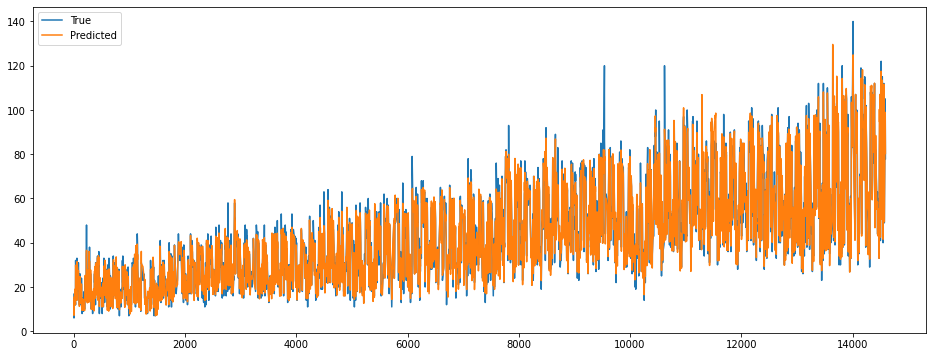

In [18]:
fig = plt.figure(figsize=[16, 6])
sns.lineplot(x=y_test.index, y=y_test.values, label='True')
sns.lineplot(x=y_test.index, y=xgb_pred_1,label='Predicted')

Hyperparameter Tuning:

In [19]:
"""
params = { 
    'max_depth' : range(2, 10, 2),
    'min_child_weight' : range(1, 4, 2),
    'gamma' : [i/10.0 for i in range(0,6)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, 
                    learning_rate =0.1,
                    random_state=1,verbosity=0), 
                    param_grid = params)
grids1.fit(X,Y)
grids1.best_params_, grids1.best_score_
"""

"\nparams = { \n    'max_depth' : range(2, 10, 2),\n    'min_child_weight' : range(1, 4, 2),\n    'gamma' : [i/10.0 for i in range(0,6)],\n    'subsample':[i/10.0 for i in range(6,10)],\n    'colsample_bytree':[i/10.0 for i in range(6,10)]\n}\ngrids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, \n                    learning_rate =0.1,\n                    random_state=1,verbosity=0), \n                    param_grid = params)\ngrids1.fit(X,Y)\ngrids1.best_params_, grids1.best_score_\n"

### Junction 2

Metric|Score
----|------
MAE | 1.645
MSE | 4.180
R Square| 92.169%

In [29]:
train_2, test_2 = train_test_split(train_j2,test_size=0.2)

In [30]:
X = train_2.drop(['Vehicles'], axis = 1)
Y = train_2['Vehicles']
x_test = test_2.drop(['Vehicles'], axis = 1)
y_test = test_2['Vehicles']

In [ ]:
# Final Model For Junction 2
xgb_2 = XGBRegressor(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=8,
                    min_child_weight=1,
                    gamma=0.0,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    verbosity = 0,
                    random_state=1)
xgb_2.fit(X, Y, eval_set=[(X, Y),(x_test,y_test)],
        early_stopping_rounds=50)

In [32]:
xgb_pred_2 = xgb_2.predict(x_test)
regressEval(y_test,xgb_pred_2, 'XGBR Junction 2')

The Meas Absolute Value of XGBR Junction 2 is 1.6937630653544704
The Meas Squared Value of the XGBR Junction 2 is 4.490746705644207
The R square score of the XGBR Junction 2 is 0.9134044319987463


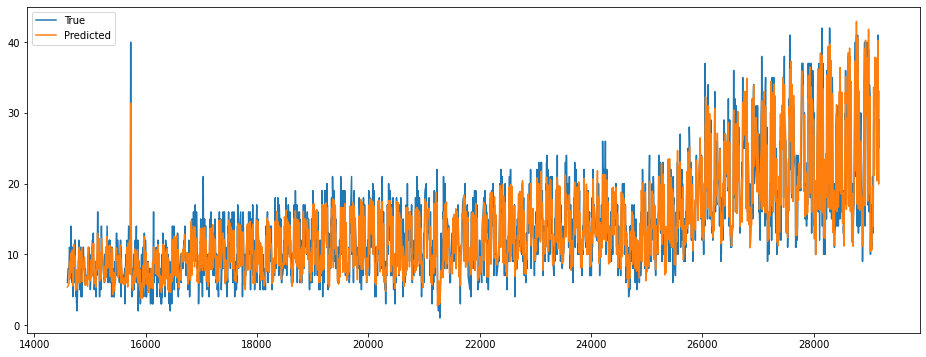

In [33]:
fig = plt.figure(figsize=[16, 6])
sns.lineplot(x=y_test.index, y=y_test.values, label='True')
sns.lineplot(x=y_test.index, y=xgb_pred_2,label='Predicted')

In [ ]:
# Hyperparameter Tuning; Takes 22 mins to run
"""
params = { 
    'max_depth' : range(4, 10, 2),
    'min_child_weight' : range(1, 4, 2),
    'gamma' : [i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,9)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, 
                    learning_rate =0.1,
                    random_state=1,verbosity=0), 
                    param_grid = params)
grids1.fit(X,Y)
grids1.best_params_, grids1.best_score_
"""

### Junction 3

Metric|Score
----|------
MAE | 2.734
MSE | 22.341
R Square| 78.773%

Model does not do well on extreme values. MSE sensitive to that.

In [35]:
train_3, test_3 = train_test_split(train_j3,test_size=0.2)

In [36]:
X = train_3.drop(['Vehicles'], axis = 1)
Y = train_3['Vehicles']
x_test = test_3.drop(['Vehicles'], axis = 1)
y_test = test_3['Vehicles']

In [ ]:
# Final Model For Junction 3 
xgb_3 = XGBRegressor(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=8,
                    min_child_weight=1,
                    gamma=0.0,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    verbosity = 0,
                    random_state=1)
xgb_3.fit(X, Y, eval_set=[(X, Y),(x_test,y_test)],
        early_stopping_rounds=30)

In [38]:
xgb_pred_3 = xgb_3.predict(x_test)
regressEval(y_test,xgb_pred_3, 'XGBR Junction 3')

The Meas Absolute Value of XGBR Junction 3 is 2.9074890810910787
The Meas Squared Value of the XGBR Junction 3 is 28.048824930740277
The R square score of the XGBR Junction 3 is 0.7703930863714594


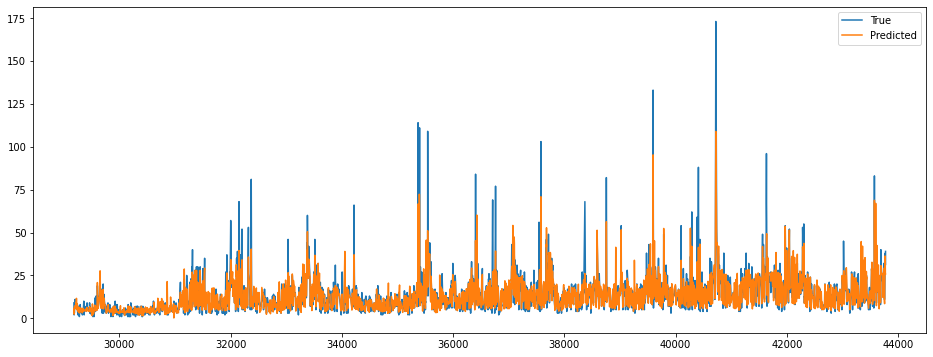

In [39]:
fig = plt.figure(figsize=[16, 6])
sns.lineplot(x=y_test.index, y=y_test.values, label='True')
sns.lineplot(x=y_test.index, y=xgb_pred_3,label='Predicted')

In [40]:
# Hyperparameter Tuning
"""
params = { 
    'max_depth' : range(2, 10, 2),
    'min_child_weight' : range(1, 4, 2),
    'gamma' : [i/10.0 for i in range(0,6)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, 
                    learning_rate =0.1,
                    random_state=1,verbosity=0), 
                    param_grid = params,
                    n_jobs = 4)
grids1.fit(X,Y)
grids1.best_params_, grids1.best_score_
"""

"\nparams = { \n    'max_depth' : range(2, 10, 2),\n    'min_child_weight' : range(1, 4, 2),\n    'gamma' : [i/10.0 for i in range(0,6)],\n    'subsample':[i/10.0 for i in range(6,10)],\n    'colsample_bytree':[i/10.0 for i in range(6,10)]\n}\ngrids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, \n                    learning_rate =0.1,\n                    random_state=1,verbosity=0), \n                    param_grid = params,\n                    n_jobs = 4)\ngrids1.fit(X,Y)\ngrids1.best_params_, grids1.best_score_\n"

### Junction 4

Metric|Score
----|------
MAE | 1.817
MSE | 6.066
R Square| 53.259%

J4 has less data, may be do DT Regress.

In [41]:
train_4, test_4 = train_test_split(train_j4,test_size=0.2)

In [42]:
X = train_4.drop(['Vehicles'], axis = 1)
Y = train_4['Vehicles']
x_test = test_4.drop(['Vehicles'], axis = 1)
y_test = test_4['Vehicles']

In [43]:
# Final Model for Junction 4
# Best hyperparameters: 
xgb_4 = XGBRegressor(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.5,
                    subsample=0.7,
                    colsample_bytree=0.8,
                    verbosity = 0,
                    random_state=1)
xgb_4.fit(X, Y, eval_set=[(X, Y),(x_test,y_test)],
        early_stopping_rounds=30)

[0]	validation_0-rmse:7.48057	validation_1-rmse:7.49063
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:7.36	validation_1-rmse:7.36938
[2]	validation_0-rmse:7.23431	validation_1-rmse:7.24421
[3]	validation_0-rmse:7.1088	validation_1-rmse:7.11863
[4]	validation_0-rmse:6.98678	validation_1-rmse:6.99799
[5]	validation_0-rmse:6.86761	validation_1-rmse:6.87778
[6]	validation_0-rmse:6.76024	validation_1-rmse:6.76949
[7]	validation_0-rmse:6.6459	validation_1-rmse:6.65445
[8]	validation_0-rmse:6.53403	validation_1-rmse:6.54226
[9]	validation_0-rmse:6.42553	validation_1-rmse:6.43351
[10]	validation_0-rmse:6.31846	validation_1-rmse:6.32634
[11]	validation_0-rmse:6.22236	validation_1-rmse:6.2298
[12]	validation_0-rmse:6.12872	validation_1-rmse:6.13499
[13]	validation_0-rmse:6.03831	validation_1-rmse:6.04409
[14]	validation_0-rmse:5.94909	validation_1-rmse:5.9542
[15

XGBRegressor(colsample_bytree=0.8, gamma=0.5, learning_rate=0.02, max_depth=4,
             min_child_weight=3, n_estimators=1000, random_state=1,
             subsample=0.7, verbosity=0)

In [44]:
xgb_pred_4 = xgb_4.predict(x_test)
regressEval(y_test,xgb_pred_4, 'XGBR Junction 4')

The Meas Absolute Value of XGBR Junction 4 is 1.737764037519659
The Meas Squared Value of the XGBR Junction 4 is 5.441775019596595
The R square score of the XGBR Junction 4 is 0.5517886103262084


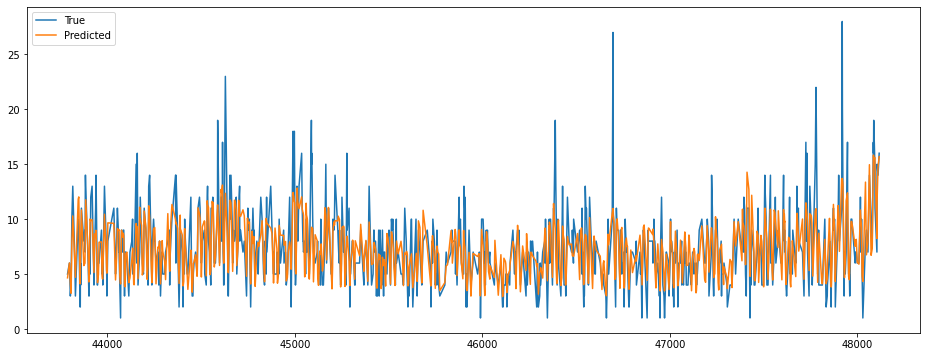

In [45]:
fig = plt.figure(figsize=[16, 6])
sns.lineplot(x=y_test.index, y=y_test.values, label='True')
sns.lineplot(x=y_test.index, y=xgb_pred_4,label='Predicted')

In [46]:
# Hyperparameter Tuning
"""
params = { 
    'max_depth' : range(2, 10, 2),
    'min_child_weight' : range(1, 4, 2),
    'gamma' : [i/10.0 for i in range(0,6)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, 
                    learning_rate =0.1,
                    random_state=1,verbosity=0), 
                    param_grid = params,
                    n_jobs = 2)
grids1.fit(X,Y)
grids1.best_params_, grids1.best_score_
"""

"\nparams = { \n    'max_depth' : range(2, 10, 2),\n    'min_child_weight' : range(1, 4, 2),\n    'gamma' : [i/10.0 for i in range(0,6)],\n    'subsample':[i/10.0 for i in range(6,10)],\n    'colsample_bytree':[i/10.0 for i in range(6,10)]\n}\ngrids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, \n                    learning_rate =0.1,\n                    random_state=1,verbosity=0), \n                    param_grid = params,\n                    n_jobs = 2)\ngrids1.fit(X,Y)\ngrids1.best_params_, grids1.best_score_\n"

##Results

In [89]:
models = [xgb_1,xgb_2,xgb_3,xgb_4]
trains = [train_j1,train_j2,train_j3,train_j4]
tests = [test_j1,test_j2,test_j3,test_j4]

In [75]:
submission = pd.Series(dtype='float64')

In [92]:
# do separate training and predition for each junction
for i in range(4):
  train = trains[i]
  test = tests[i]
  model = models[i]

  X = train.drop(['Vehicles'], axis = 1)
  Y = train['Vehicles']
  model.fit(X,Y)
  preds = model.predict(test.drop(['ID'],axis=1))
  test['Vehicles'] = preds

In [93]:
# now the predicted results are stored in each test df
test_j1.head()

,ID,Weekday,Year,Month,Day,Hour,Week,Quarter,Result
0,20170701001,5,2017,7,1,0,26,3,66.631042
1,20170701011,5,2017,7,1,1,26,3,57.423943
2,20170701021,5,2017,7,1,2,26,3,46.915928
3,20170701031,5,2017,7,1,3,26,3,39.751976
4,20170701041,5,2017,7,1,4,26,3,32.661858


In [ ]:
# merge all the predictions
submission = pd.concat(tests)

# drop unecessary columns 
submission.drop(['Weekday','Year','Month','Day',
                 'Hour','Week','Quarter'],axis=1,inplace=True)
# remove dummy index
submission.set_index(['ID'])

In [ ]:
# export results to csv
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/TS_IOT/submission_1.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  submission.to_csv(f,index=False)